<a href="https://colab.research.google.com/github/amanteur/TDA_Cover_detection/blob/main/TDA_CoverDetection_Siamese_Network_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import Input


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Extracting data

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/CourseWork/pers_feat_datasets/'

In [ ]:
df_dict = {}
for _, _, files in os.walk(root_dir):
  for file in files:
    name = file.split('.')[0]
    df = pd.read_json(root_dir + file)
    df_dict [name] = df

#Make anchor and positive samples

In [ ]:
!pip install gudhi

     |████████████████████████████████| 28.2MB 116kB/s 


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import gudhi as gd
import gudhi.representations as gdr

def data_preprocessing(data):
  data_scaled = gdr.DiagramSelector(use=True, point_type="finite").fit_transform(data)
  data_scaled = gdr.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(data_scaled)
  data_scaled = gdr.ProminentPoints(use=True, num_pts=30).fit_transform(data_scaled)
  return data_scaled

In [ ]:
def anchor_pos_neg_dfs(df_dict, df_name='ms_orig', preffered_data='Silhouette'):

  f_list = []
  df = df_dict[df_name]
  preffered_column = [c for c in df.columns if preffered_data in c][0]
  #for diagrams
  # for i, row in df.iterrows():
  #   diag = [np.array(row[preffered_column])]
  #   diag = data_preprocessing(diag)
  #   diag_list.append(diag[0])
  for i, row in df.iterrows():
    f = np.array(row[preffered_column]).flatten()
    f_list.append(f)

  anchors_df = df.drop_duplicates(subset=['name'])
  anchor_ids = anchors_df.index
  pos_df = df.drop( df.index[anchor_ids]).drop_duplicates(subset=['name'])
  pos_ids = pos_df.index

  anchor_diags = [f_list[i] for i in anchor_ids]
  pos_diags = [f_list[i] for i in pos_ids]
  labels = anchors_df.name.tolist()
  return anchor_diags, pos_diags, labels

In [ ]:
anchor, pos, labels = anchor_pos_neg_dfs(df_dict)

In [ ]:
songs_count = len(anchor)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor)
pos_dataset = tf.data.Dataset.from_tensor_slices(pos)

In [ ]:
neg = anchor + pos
np.random.RandomState(seed=32).shuffle(neg)

negative_dataset = tf.data.Dataset.from_tensor_slices(neg)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, pos_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

In [ ]:
dataset

<ShuffleDataset shapes: ((500,), (500,), (500,)), types: (tf.float64, tf.float64, tf.float64)>

In [ ]:
#train and test
train_dataset = dataset.take(round(songs_count * 0.6))
val_dataset = dataset.skip(round(songs_count * 0.7))
val_dataset = val_dataset.skip(round(songs_count * 0.9))
test_dataset = dataset.skip(round(songs_count * 0.9))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

test_dataset = test_dataset.batch(32, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 500), (None, 500), (None, 500)), types: (tf.float64, tf.float64, tf.float64)>

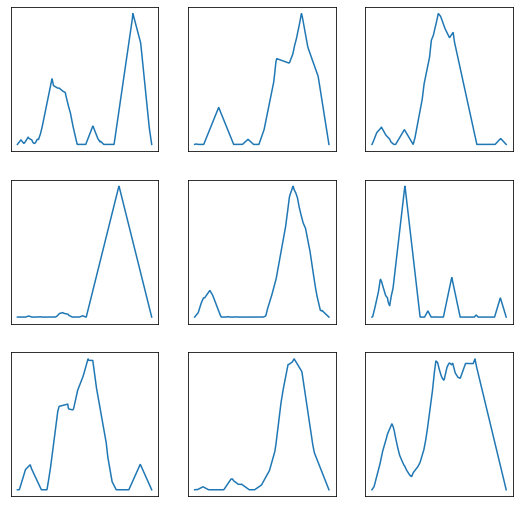

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.plot(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Model

In [ ]:
target_shape = (500,)

In [ ]:
nn_input = Input(shape=(500,), name='INPUT')
flatten = layers.Flatten()(nn_input)
dense1 = layers.Dense(256, activation="relu", name='Dense1')(flatten)
dense1 = layers.BatchNormalization(name='Batch1')(dense1)
dense2 = layers.Dense(128, activation="relu", name='Dense2')(dense1)
dense2 = layers.BatchNormalization(name='Batch2')(dense2)
output = layers.Dense(128, name='Dense3')(dense2)

embedding = Model(nn_input, output, name="Embedding")
print(embedding.summary())

Model: "Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 500)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               128256    
_________________________________________________________________
Batch1 (BatchNormalization)  (None, 256)               1024      
_________________________________________________________________
Dense2 (Dense)               (None, 128)               32896     
_________________________________________________________________
Batch2 (BatchNormalization)  (None, 128)               512       
_________________________________________________________________
Dense3 (Dense)               (None, 128)               16

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape)
negative_input = layers.Input(name="negative", shape=target_shape)

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
2/2 [==============================] - 1s 23ms/step - loss: 0.4909
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5117
Epoch 3/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5259
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 0.5128
Epoch 5/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4743
Epoch 6/100
2/2 [==============================] - 0s 20ms/step - loss: 0.4976
Epoch 7/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5042
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.5034
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4930
Epoch 10/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5068
Epoch 11/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4868
Epoch 12/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5056
Epoch 13/100
2/2 [==============================]

In [ ]:
pos_sim = []
neg_sim = []
for i in range(64):
  sample = next(iter(test_dataset))
  anchor, positive, negative = sample
  y_pred = siamese_model.predict([anchor, positive, negative])

  anchor_embedding, positive_embedding, negative_embedding = (
      embedding(anchor),
      embedding(positive),
      embedding(negative),
  )

  cosine_similarity = metrics.CosineSimilarity()
  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
  pos_sim.append(positive_similarity)
  neg_sim.append(negative_similarity)

  if i % 10 == 0:
    print('sample ', i)
    print(y_pred)


    print("Positive similarity:", positive_similarity.numpy())
    print("Negative similarity", negative_similarity.numpy())
print('\nMean positive similarity:', np.mean(pos_sim))
print('\nMean negative similarity:', np.mean(neg_sim))

sample  0
(array([0.08976854, 0.02134169, 0.2124488 , 0.10684183, 0.33488953,
       0.1427098 , 0.12306878, 0.2652594 ], dtype=float32), array([0.5856374 , 0.03668496, 0.06218493, 0.7609694 , 0.24213111,
       0.35175422, 0.80018055, 0.25222793], dtype=float32))
Positive similarity: 0.7971003
Negative similarity 0.7283498
sample  10
(array([0.10684183, 0.34243485, 0.1738712 , 0.9275155 , 0.05996846,
       0.25576094, 0.22740875, 0.02147042], dtype=float32), array([1.1039845 , 0.33153182, 0.22679856, 1.4702811 , 0.22653939,
       1.5363348 , 0.0800132 , 0.14266002], dtype=float32))
Positive similarity: 0.78017265
Negative similarity 0.7019845
sample  20
(array([0.05931036, 0.3532762 , 0.52523065, 0.33488953, 0.0907187 ,
       0.05220813, 0.02784101, 0.22740875], dtype=float32), array([0.08606778, 0.10000977, 0.5131359 , 0.7161581 , 0.67679316,
       0.33023372, 0.5994896 , 0.12033451], dtype=float32))
Positive similarity: 0.6716742
Negative similarity 0.6309819
sample  30
(array([

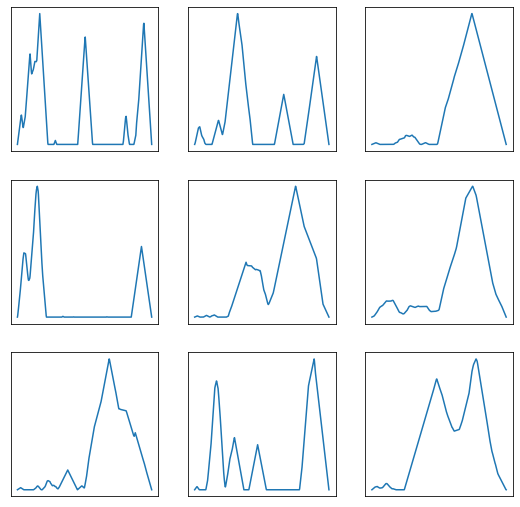

In [ ]:
visualize(*sample)